Add Robin boundary conditions.

For Disc 3, we have considered the 1: heat conduction, we need heat convection with ambient temperature and radiation.

Maybe need go to variation form to derive the heat transfer equation.

Author: yanjun zhang

# ds needs define correct

## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

In [2]:
import pyvista
import ufl
import dolfinx
import time
import numpy as np
import matplotlib.pyplot as plt
from petsc4py import PETSc
from mpi4py import MPI
import sys

from dolfinx.fem.petsc import LinearProblem,assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from dolfinx import fem, mesh, io, plot, default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, 
                         form,  locate_dofs_topological)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import  locate_entities, locate_entities_boundary,meshtags
from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner, Measure, dot, FacetNormal)

from find_com_e import find_common_e

# Start time, Final time ,Time step
t = 0
Total_time = 5
num_steps  = 30
# time step size
dt = Total_time / num_steps  

# initial and brake pad temperature
Ti = 25
Tm = 25

# density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
t_u = 1e3 # m to mm
rho = 7850 /(t_u**3)
c = 462
k = 48 / t_u

# mu, P_brake, v_angualr , r_disc , heat_distribution
mu = 0.35
P_brake = 246000
v_angualr = 48.3
r_disc = 0.25
heat_distribution = 0.88

# S_or is the original brake pad rubbing area, 200 cm2. 
S_or = 200
S_new = 200

# g is the heat source,unit is w/mm2
g = mu * P_brake * v_angualr * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) 
print(v_angualr * r_disc * dt *1000)
print(g)

2012.4999999999998
1.8297971999999998


In [3]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

DOLFINx version: 0.7.3   based on GIT commit:  ubuntu of https://github.com/FEniCS/dolfinx/


## 2: Mesh

In [4]:
# mesh
filename = "3-10" 
domain, cell_markers, facet_markers = gmshio.read_from_msh(filename+".msh", MPI.COMM_WORLD, 0, gdim=3)

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('CG', 1))

# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()
    
# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = FunctionSpace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init,V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 50) )
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V)

Info    : Reading '3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading '3-10.msh'


In [5]:
print(type(PETSc.ScalarType(Tm)))
print(fem.locate_dofs_topological(V, fdim, bc_disc))
print(bc)

<class 'numpy.float64'>
[]


## 3: Setup output


In [6]:
xdmf = io.XDMFFile(domain.comm, "T4.xdmf", "w")
xdmf.write_mesh(domain)


boundaries = []
for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
    vari_name = 10*i
    boundaries.append(  (vari_name, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324)  )

In [7]:
# Create boundary condition

sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
from rub_co import get_rub_coordinate
x_co, y_co = get_rub_coordinate()

boundary1= (10, lambda x: (x[0]-x_co[0])**2 + (x[1]-y_co[0])**2 <= 324)
boundary2= (20, lambda x: (x[0]-x_co[1])**2 + (x[1]-y_co[1])**2 <= 324) 
boundary3= (30, lambda x: (x[0]-x_co[2])**2 + (x[1]-y_co[2])**2 <= 324)
boundary4= (40, lambda x: (x[0]-x_co[3])**2 + (x[1]-y_co[3])**2 <= 324) 
boundary5= (50, lambda x: (x[0]-x_co[4])**2 + (x[1]-y_co[4])**2 <= 324)
boundary6= (60, lambda x: (x[0]-x_co[5])**2 + (x[1]-y_co[5])**2 <= 324) 
boundary7= (70, lambda x: (x[0]-x_co[6])**2 + (x[1]-y_co[6])**2 <= 324)
boundary8= (80, lambda x: (x[0]-x_co[7])**2 + (x[1]-y_co[7])**2 <= 324) 
boundary9= (90, lambda x: (x[0]-x_co[8])**2 + (x[1]-y_co[8])**2 <= 324)
boundary10= (100, lambda x: (x[0]-x_co[9])**2 + (x[1]-y_co[9])**2 <= 324) 
boundary11= (110, lambda x: (x[0]-x_co[10])**2 + (x[1]-y_co[10])**2 <= 324)
boundary12= (120, lambda x: (x[0]-x_co[11])**2 + (x[1]-y_co[11])**2 <= 324) 
boundary13= (130, lambda x: (x[0]-x_co[12])**2 + (x[1]-y_co[12])**2 <= 324)
boundary14= (140, lambda x: (x[0]-x_co[13])**2 + (x[1]-y_co[13])**2 <= 324) 
boundary15= (150, lambda x: (x[0]-x_co[14])**2 + (x[1]-y_co[14])**2 <= 324)
boundary16= (160, lambda x: (x[0]-x_co[15])**2 + (x[1]-y_co[15])**2 <= 324)
boundary17= (170, lambda x: (x[0]-x_co[16])**2 + (x[1]-y_co[16])**2 <= 324) 
boundary18= (180, lambda x: (x[0]-x_co[17])**2 + (x[1]-y_co[17])**2 <= 324)
#boundary19= (190, lambda x: (x[0]         )**2 + (x[1]         )**2 <= 320**2)

boundaries = [boundary1,boundary2,boundary3,boundary4,boundary5,boundary6,boundary7,boundary8,boundary9,
              boundary11,boundary12,boundary13,boundary14,boundary15,boundary16,boundary17,boundary18]

facet_indices, facet_markers = [], [] 
fdim = domain.topology.dim - 1  

for (marker, locator) in boundaries:
    facets = locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)

bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 20) )
facet_indices = np.intersect1d(bc_disc, facet_indices)

sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


In [15]:
#print(facet_indices)
boundary19= (190, lambda x: (x[0])**2 + (x[1])**2 <= 320**2)
boundaries1 = boundaries + [boundary19]

facet_indices1, facet_markers1 = [], [] 
fdim = domain.topology.dim - 1  
for (marker, locator) in boundaries1:
    facets = locate_entities(domain, fdim, locator)
    facet_indices1.append(facets)
    facet_markers1.append(np.full_like(facets, marker))
    
facet_indices1 = np.hstack(facet_indices1).astype(np.int32)
facet_markers1 = np.hstack(facet_markers1).astype(np.int32)

bc_disc1 = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 20) )
facet_indices1 = np.intersect1d(bc_disc1, facet_indices1)
print(len(facet_indices1))
print(len(bc_disc1))
print(facet_markers1)
print(facet_indices1)

5767
5950
[ 10  10  10 ... 190 190 190]
[    3    11    17 ... 82553 82561 82571]


## 4: Variational equation


In [7]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init,V)
xdmf.write_function(uh, t)

u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n = FacetNormal(domain)
#h = g/20000
h = 0

#a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx +  h * inner( u, v) *ds(10)
a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx 
#L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx  +  h * 25* v *ds(10)
L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx  

for i in list(range(1,19)):
     a +=   -  k * dot( grad(u)* v, n) *ds(10*i)

     L +=   +  inner(g, v) *ds(10*i)

# assembly matrix and vector
bilinear_form = fem.form(a)
linear_form = fem.form(L)

A = assemble_matrix(bilinear_form)
A.assemble()
b = create_vector(linear_form)
## 7: Using petsc4py to create a linear solver
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl
pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()
plotter.open_gif("T4.gif", fps=30)
grid.point_data["Temperature"] = uh.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)
renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[0,  200])

## 5: Solution


1: Rotation has applied for 10 degree. 2: Current time is 0.2 s. 3: Completion is 3.3 %. 

  warnings.warn(

  warnings.warn(



1: Rotation has applied for 300 degree. 2: Current time is 5.0 s. 3: Completion is 100.0 %.  Current time is 1.3 s. 3: Completion is 26.7 %. 


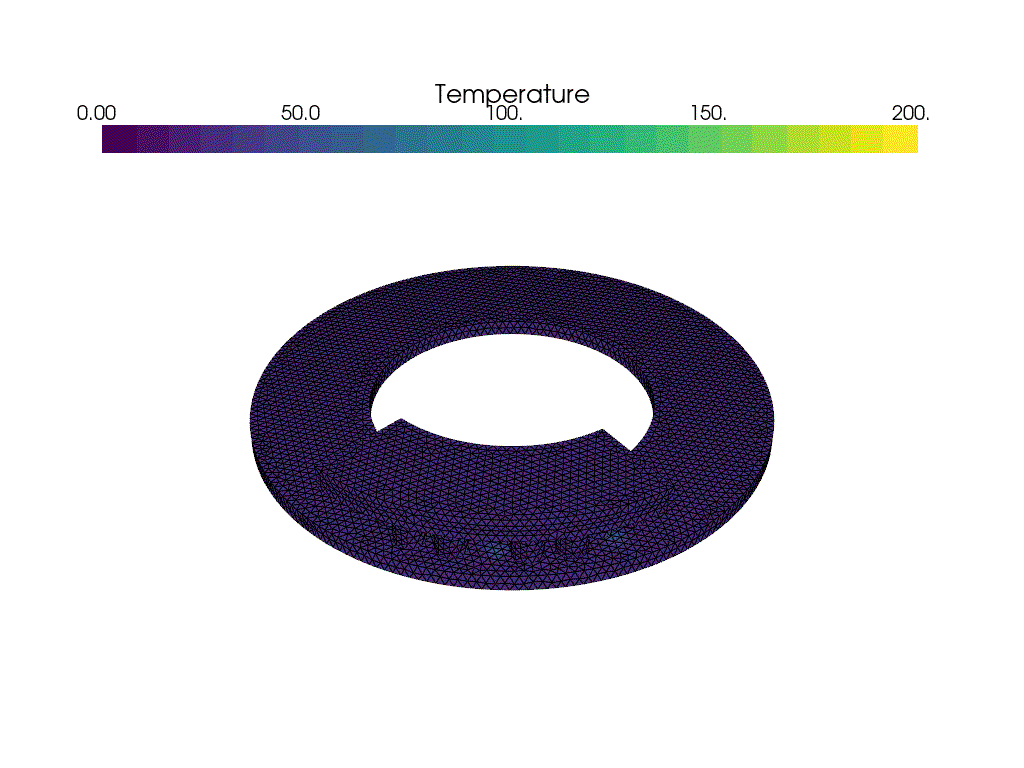

In [8]:
from rotation_co import rub_rotation
import numpy as np

degree = 10
total_degree = 0

for i in range(num_steps):
    t += dt
   
    boundaries = []
    x_co, y_co = rub_rotation (x_co, y_co, degree)   # update the location
    total_degree += degree  # Incrementing degree by 10 in each step
    
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/Total_time),1) )+ " %. ")
    sys.stdout.flush()
    
    boundary1= (10, lambda x: (x[0]-x_co[0])**2 + (x[1]-y_co[0])**2 <= 324)
    boundary2= (20, lambda x: (x[0]-x_co[1])**2 + (x[1]-y_co[1])**2 <= 324) 
    boundary3= (30, lambda x: (x[0]-x_co[2])**2 + (x[1]-y_co[2])**2 <= 324)
    boundary4= (40, lambda x: (x[0]-x_co[3])**2 + (x[1]-y_co[3])**2 <= 324) 
    boundary5= (50, lambda x: (x[0]-x_co[4])**2 + (x[1]-y_co[4])**2 <= 324)
    boundary6= (60, lambda x: (x[0]-x_co[5])**2 + (x[1]-y_co[5])**2 <= 324) 
    boundary7= (70, lambda x: (x[0]-x_co[6])**2 + (x[1]-y_co[6])**2 <= 324)
    boundary8= (80, lambda x: (x[0]-x_co[7])**2 + (x[1]-y_co[7])**2 <= 324) 
    boundary9= (90, lambda x: (x[0]-x_co[8])**2 + (x[1]-y_co[8])**2 <= 324)
    boundary10= (100, lambda x: (x[0]-x_co[9])**2 + (x[1]-y_co[9])**2 <= 324) 
    boundary11= (110, lambda x: (x[0]-x_co[10])**2 + (x[1]-y_co[10])**2 <= 324)
    boundary12= (120, lambda x: (x[0]-x_co[11])**2 + (x[1]-y_co[11])**2 <= 324) 
    boundary13= (130, lambda x: (x[0]-x_co[12])**2 + (x[1]-y_co[12])**2 <= 324)
    boundary14= (140, lambda x: (x[0]-x_co[13])**2 + (x[1]-y_co[13])**2 <= 324) 
    boundary15= (150, lambda x: (x[0]-x_co[14])**2 + (x[1]-y_co[14])**2 <= 324)
    boundary16= (160, lambda x: (x[0]-x_co[15])**2 + (x[1]-y_co[15])**2 <= 324)
    boundary17= (170, lambda x: (x[0]-x_co[16])**2 + (x[1]-y_co[16])**2 <= 324) 
    boundary18= (180, lambda x: (x[0]-x_co[17])**2 + (x[1]-y_co[17])**2 <= 324)
    #boundary19= (190, lambda x:  x[2]                                   == 20)


    boundaries = [boundary1,boundary2,boundary3,boundary4,boundary5,boundary6,boundary7,boundary8,boundary9,
              boundary11,boundary12,boundary13,boundary14,boundary15,boundary16,boundary17,boundary18]
    #boundaries = boundaries+ [boundary19]

    facet_indices, facet_markers = [], [] 
    fdim = domain.topology.dim - 1  
    for (marker, locator) in boundaries:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)

    bc_disc = mesh.locate_entities_boundary( domain, fdim , lambda x:  np.isclose(x[2], 20) )
    facet_indices = np.intersect1d(bc_disc, facet_indices)

    sorted_facets = np.argsort(facet_indices)
    facet_tag = meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])
    ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


    #a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx +  h * inner( u, v) *ds(10)
    a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx 
    #L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx  +  h * 25* v *ds(10)
    L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx  

    for i in list(range(1,19)):
        a +=   -  k * dot( grad(u)*v, n) *ds(10*i)
        L +=   +  inner(g, v) *ds(10*i)
    
    bilinear_form = fem.form(a)
    linear_form = fem.form(L)
    b = create_vector(linear_form)
    A = assemble_matrix(bilinear_form, bcs=[bc])
    A.assemble()
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)
    
    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)
    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])
    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array
    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()

# Display the GIF
from IPython.display import display, Image
display(Image(filename = 'T4.gif'))

In [9]:
print(a)

{ 0.0217602 * v_1 * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 0.048 * (conj(((grad(v_0)) : (grad(v_1))))) } * dx(<Mesh #0>[everywhere], {})
  +  { -0.048 * (({ A | A_{i_{548}} = (grad(v_1))[i_{548}] * v_0 }) . (n)) } * ds(<Mesh #0>[10], {})
  +  { -0.048 * (({ A | A_{i_{549}} = (grad(v_1))[i_{549}] * v_0 }) . (n)) } * ds(<Mesh #0>[20], {})
  +  { -0.048 * (({ A | A_{i_{550}} = (grad(v_1))[i_{550}] * v_0 }) . (n)) } * ds(<Mesh #0>[30], {})
  +  { -0.048 * (({ A | A_{i_{551}} = (grad(v_1))[i_{551}] * v_0 }) . (n)) } * ds(<Mesh #0>[40], {})
  +  { -0.048 * (({ A | A_{i_{552}} = (grad(v_1))[i_{552}] * v_0 }) . (n)) } * ds(<Mesh #0>[50], {})
  +  { -0.048 * (({ A | A_{i_{553}} = (grad(v_1))[i_{553}] * v_0 }) . (n)) } * ds(<Mesh #0>[60], {})
  +  { -0.048 * (({ A | A_{i_{554}} = (grad(v_1))[i_{554}] * v_0 }) . (n)) } * ds(<Mesh #0>[70], {})
  +  { -0.048 * (({ A | A_{i_{555}} = (grad(v_1))[i_{555}] * v_0 }) . (n)) } * ds(<Mesh #0>[80], {})
  +  { -0.048 * (({ A | A_{i_{556}} = (

In [10]:
print(L)

{ c_0 * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 0.0217602 * u_n * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[10], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[20], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[30], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[40], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[50], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[60], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[70], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[80], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[90], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[100], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[110], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[120], {})
  +  { 1.8297971999999998 * (conj((v_0))) } * ds(<Me